## 1. Using Kaggle token to download the data and process it over cloud

In [4]:
#kaggle json key to get data from kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vaibhavm31","key":"8d5952d48a3132cc1ada26483aa2039e"}'}

In [5]:
def get_data():
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -p /content
  !unzip \*.zip

In [6]:
get_data()

 98% 709M/723M [00:05<00:00, 146MB/s]
100% 723M/723M [00:05<00:00, 131MB/s]
Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: all_data.csv            
  inflating: identity_individual_annotations.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_private_expanded.csv  
  inflating: test_public_expanded.csv  
  inflating: toxicity_individual_annotations.csv  
  inflating: train.csv               


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# 3. Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tqdm import tqdm
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report
%matplotlib inline
warnings.filterwarnings("ignore")
from IPython.display import Image,YouTubeVideo,HTML

#KERAS Import
from keras.models import Sequential, Model
from keras.utils import to_categorical,plot_model
from keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization
from keras.initializers import he_normal
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Embedding, LSTM, GRU, MaxPooling1D, Flatten, Input, concatenate, Conv1D, GlobalMaxPool1D, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GlobalAveragePooling1D, add
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras.preprocessing.text import one_hot
from keras.constraints import max_norm
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

#for attention mechanism
from keras import backend as K
#from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
!git clone https://github.com/ellamguest/online-misogyny-eacl2021.git

Cloning into 'online-misogyny-eacl2021'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 195 (delta 10), reused 190 (delta 8), pack-reused 0
Receiving objects: 100% (195/195), 15.08 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
# df = pd.read_csv('train.csv')
# df.head()
df_l = pd.read_csv("final_labels.csv", sep=',', encoding='utf-8', dtype = str, keep_default_na=False, skip_blank_lines=False, converters={'body':lambda x:x.replace('/n','')})

# df2 = df2.loc[df2['male'] > 0.0]
len(df_l.head())


5

In [14]:
df = pd.read_csv('train.csv')
# we only care about male and female


In [17]:
df = df.loc[(df['male'] > 0.5) | (df['female'] > 0.5) ]

In [ ]:
df

In [20]:
test_df = pd.read_csv('test.csv')

In [21]:
print(df.iloc[28]['comment_text'])
print("Toxicity Level: ",df.iloc[28]['target'])

Girl Scouts should set up tables outside of pot retailers.
Toxicity Level:  0.0


In [22]:
print(df.iloc[4]['comment_text'])
print("Toxicity Level: ",df.iloc[4]['target'])

To meet these people with threats of violence and/or humiliation, or anything other than personal dignity is playing right into their hand or opening "this side" up to opposition, and adding energy to their game. I agree in shutting off power and phone, jamming wi-if and blocking any access into the area. You didn't plan well and forgot necessities? Tough. What happens when you go camping and forgot to pack whatever? You go without, borrow from your mates, (if they're willing to share) or cut the trip short. Y'all got yourselves into this jam, don't be expecting for those you are flipping off to be accomadating. As a sign in a supply house said, "Poor planning on your part, does not constitute an emergency on ours". Read 'em and weep, girls. Oh, and I'd say, last one out, turn down the heat and turn off the lights, but if it were up to me, you wouldn't have to worry about it
Toxicity Level:  0.2


In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
# https://gist.github.com/sebleier/554280
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [25]:
# Combining all the above statemennts 
preprocessed_comments = []
# tqdm is for printing the status bar
for sentence in tqdm(df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() )
    preprocessed_comments.append(sent.lower().strip())

100%|██████████| 74113/74113 [00:05<00:00, 14214.64it/s]


In [27]:
df['comment_text'] = preprocessed_comments

In [29]:
preprocessed_comments_test = []
# tqdm is for printing the status bar
for sentence in tqdm(test_df['comment_text'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split())
    preprocessed_comments_test.append(sent.lower().strip())

100%|██████████| 97320/97320 [00:03<00:00, 27847.63it/s]


In [31]:
test_df['comment_text'] = preprocessed_comments_test

In [32]:
train_len = len(df.index)

In [33]:
miss_val_train_df = df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

parent_id    44.904403
dtype: float64

# 6. Data Preprocessing

In [34]:
identity_columns = ['male', 'female'] # 'homosexual_gay_or_lesbian', 'christian', 'jewish','muslim', 'black', 'white', 'psychiatric_or_mental_illness']

In [35]:
for column in identity_columns + ['target']:
    df[column] = np.where(df[column] >= 0.5, True, False)

In [36]:
# Target variable as well
y = df['target'].values

In [37]:
y

array([False,  True, False, ..., False, False, False])

In [38]:
train_df, cv_df, y_train, y_cv = train_test_split(df, y, test_size=0.2, random_state=42)

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [40]:
train_tfidf = vectorizer.fit_transform(train_df["comment_text"])
cv_tfidf = vectorizer.transform(cv_df["comment_text"])
test_tfidf = vectorizer.transform(test_df["comment_text"])

In [41]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix,index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [42]:
def threshold_based_prediction(proba,threshold,tpr,fpr):
    thres = threshold[np.argmax(fpr*(1-tpr))]
    predictions = []
    for i in proba:
        if i>=thres:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# 7. Baseline - Logistic Regression model

### Using TFIDF vectorized data

In [43]:
alpha = [10 ** x for x in range(-5, 2)]
auc_array_train=[]
auc_array_cv=[]
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=5,class_weight='balanced')
  clf.fit(train_tfidf, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(train_tfidf, y_train)
  
    
    
  predict_y_train = sig_clf.predict_proba(train_tfidf)[:,1]
  predict_y = sig_clf.predict_proba(cv_tfidf)[:,1]
  auc_array_train.append(roc_auc_score(y_train, predict_y_train))
  auc_array_cv.append(roc_auc_score(y_cv, predict_y))
  print('For values of alpha = ', i, "The auc score on CV is:",roc_auc_score(y_cv, predict_y))

For values of alpha =  1e-05 The auc score on CV is: 0.861585503882638


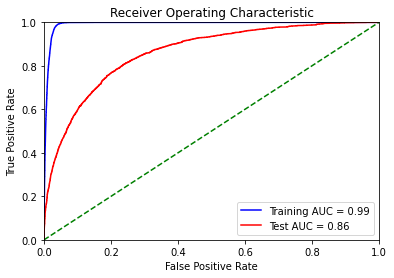

In [44]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr_train, tpr_train, threshold_train = roc_curve(y_train, predict_y_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_cv, predict_y)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


plt.title('Receiver Operating Characteristic')

plt.plot(fpr_train, tpr_train, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
clf = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05,
                                                    class_weight='balanced',
                                                    loss='log',
                                                    random_state=42))

### Results

In [ ]:
predtrain = sig_clf.predict_proba(train_tfidf)[:,1]
print(len(predtrain))
train_df['pred_log'] = predtrain >= 0.5
predcv = sig_clf.predict_proba(cv_tfidf)[:,1]
pred = sig_clf.predict_proba(test_tfidf)[:,1]
train_df

In [ ]:
cv_df['pred_log'] = predcv >= 0.5

In [ ]:
train_df.to_csv('pop_model_2.csv', index=False)


	TRAIN DATA CONFUSION MATRIX


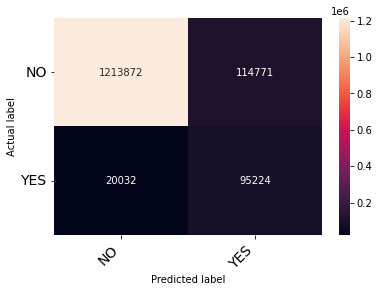

In [ ]:
predtrain = threshold_based_prediction(predtrain,threshold_train,tpr_train,fpr_train)
cm = confusion_matrix(y_train, predtrain)
print("\tTRAIN DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

	TEST DATA CONFUSION MATRIX


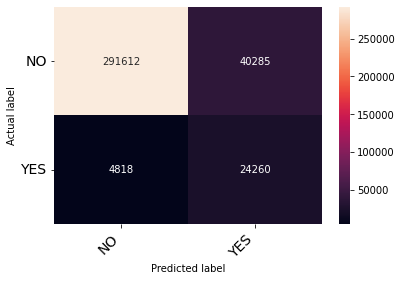

In [ ]:
predcv = threshold_based_prediction(predcv,threshold_test,tpr_test,fpr_test)
cm = confusion_matrix(y_cv, predcv)
print("\tTEST DATA CONFUSION MATRIX")
print_confusion_matrix(cm,class_names=['NO','YES'])

### AUC scores

In [ ]:
auc = roc_auc_score(y_train, predtrain)
print('\nTRAIN AUC on CV data is %f' % (auc))


TRAIN AUC on CV data is 0.869907


In [ ]:
auc = roc_auc_score(y_cv, predcv)
print('\nTEST AUC on CV data is %f' % (auc))


TEST AUC on CV data is 0.856465


### F1 Score

In [ ]:
print(classification_report(y_cv,predcv))

              precision    recall  f1-score   support

       False       0.98      0.88      0.93    331897
        True       0.38      0.83      0.52     29078

    accuracy                           0.88    360975
   macro avg       0.68      0.86      0.72    360975
weighted avg       0.93      0.88      0.90    360975



### Metrics definition

In [45]:
# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90986#latest-527331
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'target'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [47]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [48]:
import keras
MAX_VOCAB_SIZE = 100000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'
MAX_SEQUENCE_LENGTH = 300

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
def padding_text(texts, tokenizer):
    return keras.utils.pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [49]:
train_text = padding_text(train_df[TEXT_COLUMN], tokenizer)
train_y = to_categorical(train_df[TOXICITY_COLUMN])
validate_text = padding_text(cv_df[TEXT_COLUMN], tokenizer)
validate_y = to_categorical(cv_df[TOXICITY_COLUMN])

In [50]:
NUM_EPOCHS = 10
BATCH_SIZE = 512

In [51]:
# https://fasttext.cc/docs/en/english-vectors.html
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2022-12-16 02:38:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  35.3MB/s    in 36s     

2022-12-16 02:39:02 (39.9 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [52]:
!unzip crawl*.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


#### Creating the embedding matrix for the embedding layer

In [53]:
embeddings_index = {}
with open('crawl-300d-2M.vec' ,encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [54]:
len(tokenizer.word_index)

64629

In [56]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,300))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    num_words_in_embedding += 1
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

In [57]:
embedding_matrix.shape

(64630, 300)

#### Model building and training

#### Model building

## Using LSTM - Birectional LSTM and sample weights

### Model building

In [58]:
input_text_blstm = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedding_layer_blstm = Embedding(len(tokenizer.word_index) + 1,
                                    300,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
b = embedding_layer_blstm(input_text_blstm)
b = SpatialDropout1D(0.2)(b)
b = Bidirectional(LSTM(128, return_sequences=True))(b)
b = Bidirectional(LSTM(128, return_sequences=True))(b)
b = GlobalMaxPooling1D()(b)
b = Dense(512, activation='relu')(b)
b = Dense(512, activation='relu')(b)
blstm_output = Dense(2, activation='softmax')(b)

In [59]:
model = Model(inputs=[input_text_blstm], outputs=[blstm_output])

In [60]:
# https://www.kaggle.com/kernels/scriptcontent/16109977/download
sample_weights = np.ones(len(train_text), dtype=np.float32)
sample_weights += train_df[identity_columns].sum(axis=1) * 3
sample_weights += train_df[TOXICITY_COLUMN] * (~train_df[identity_columns]).sum(axis=1) * 3
sample_weights += (~train_df[TOXICITY_COLUMN]) * train_df[identity_columns].sum(axis=1) * 9
sample_weights /= sample_weights.mean()

In [61]:
[sample_weights.values, np.ones_like(sample_weights)]

[array([0.8817426 , 0.8817426 , 0.8817426 , ..., 0.8817426 , 0.8817426 ,
        0.47478447]), array([1., 1., 1., ..., 1., 1., 1.])]

### Model training

In [62]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [63]:
NUM_EPOCHS = 10

In [64]:
BLSTM_Model = model.fit(train_text,train_y,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_y),
              sample_weight = [sample_weights.values])

116/116 [==============================] - 53s 367ms/step - loss: 0.2284 - accuracy: 0.8503 - val_loss: 0.2908 - val_accuracy: 0.8780


### Results

In [65]:
# Prediction on data, takes time because in the end this is run on all the GPT-2 outputs
MODEL_NAME = 'blstm_model'
cv_df[MODEL_NAME] = model.predict(validate_text)[:, 1]

464/464 [==============================] - 16s 29ms/step


In [66]:
bias_metrics_df = compute_bias_metrics_for_model(cv_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,male,8344,0.876342,0.869748,0.888968
1,female,10264,0.879063,0.909288,0.843040


In [68]:
df.to_csv('pop_model2.csv')

In [67]:
get_final_metric(bias_metrics_df, calculate_overall_auc(cv_df, MODEL_NAME))

0.8772862145604501